<a href="https://colab.research.google.com/github/wildfish-mail-ru/ML/blob/master/journal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация заявок в Журнале обходов

## 0. Подготовка блокнота Colab к работе

В начале работы не забудьте переключить мощности используемого блокнота Google Colaboratory на графический процессор, выбрав пункт меню *Runtime-Change Runtime type*. В появившемся окне, выберите в списке *Hardware accelerator* пункт *GPU*, нажмите ОК. Так вы получите бесплатную мощность одного GPU (NVidia Tesla K80). Но помните, что "после 12 часов карета превратится в тыкву!" и через 12 часов использования выданная виртуальная машина будет сброшена и все данные, сохранённые вами, будут удалены.

Так же не забудьте загрузить файлы данных (*journals.txt* и *journals-lemma.txt*), запустив следующий код. После этого файлы станут нам доступны, в чём можно убедиться, увидев их на закладке *Files*.

In [0]:
# скачаем файлы данных
import urllib.request
# скачаем архивы
urllib.request.urlretrieve('https://drive.google.com/uc?id=13U0-73yp6vdG29OPpGUkKhjeGNWUQd5z&export=download', 'journals.zip')
urllib.request.urlretrieve('https://drive.google.com/uc?id=1b1XniAQhXKfjQvB5XavPsX0SALqugWEQ&export=download', 'journals-lemma.zip')
# распакуем архивы
!unzip journals.zip
!unzip journals-lemma.zip

KeyboardInterrupt: ignored

## 1. Постановка задачи

Есть выгрузка текста заявок из "Журнала обходов" и присвоенный этим заявкам класс. Задача - построить модель нейронной сети, которая сама будет классифицировать новые заявки по их тексту.



## 2. Загрузка данных

Нам понадобится несколько вспомогательных библиотек. Объявим их импорт.

In [0]:
import pandas as pd   # высокоуровневая библиотека для анализа данных
import numpy as np    # работа с многомерными массивовами
import scipy as sp    # расширяет функционал numpy функциями линейной алгебры
import re             # работа с регулярными выражениями
from keras.preprocessing.text import Tokenizer         # обработка слов
from keras.preprocessing.sequence import pad_sequences # дополнение последовательностей
from sklearn.preprocessing import OneHotEncoder        # унитарное кодирование
from keras.models import Sequential                    # многослойная модель
from keras.layers import Embedding, SpatialDropout1D, Dense, LSTM # используемые модели в слоях
from sklearn.model_selection import train_test_split   # разбиение данных на обучающий и проверочный наборы
from matplotlib import pyplot # построение графиков
from keras.callbacks import EarlyStopping # ранняя остановка при обучении

Using TensorFlow backend.


Выгрузка текста заявок и их классы хранятся в файле "journals.txt". Загрузим данные и посмотрим, что там за данные.

In [0]:
texts = pd.read_csv("journals.txt", sep = "\t")
texts.dropna()
print("Размер массива данных = ", texts.shape)

print("\nПример данных =")
print(texts.head(10))

Размер массива данных =  (123966, 2)

Пример данных =
                                                Text  Code
0  От переходной галереи диагностического центра ...     1
1                   Нет допуска ЗГИэ в здание ДГСАЭ.     1
2           Подклинивает наружную дверь шлюза БЩУ-4.     1
3  Розетки, к которым подключена досмотровая уста...     1
4  Выполнен обход по маршрутам № 4; 7. Ответная п...     1
5  Слетели крышки с нескольких коробов на ограждении     1
6  Выполнен обход по маршруту № 5. Обход БНС-2 не...     1
7  Выполнен обход по маршрутам № 15. На БЩУ-1 на ...     1
8  АЛК, КПП, рентгенустановка, разобраться с "пил...     1
9  Выполнен обход по маршруту № 5. На БНС-2 обход...     1


Массив содержит 123966 записей и 2 столбца. Название этих столбцов носят соответствующие содержанию названия - "Text" и "Code".
Посмотрим, какого рода там текст, возможно ли его использовать для обучения модели и какого распределние данных по классам заявок.


Пример текста заявок =
123946    (Для ЦТАИ) БЩУ-1. СВРК. Периодически отбраковы...
123947    Выполнен обход по маршрутам № 35; 44. Замечани...
123948    Выполнен обход по маршрутам № 35; 41. Записано...
123949    Второй абзац п. 4.3.1 "Производственной инстру...
123950    Выполнен обход по маршрутам № 35; 40.Замечания...
123951    На постаменте реактора блока 2 не работает тел...
123952    Выполнен обход по маршрутам № 35; 42. Записоно...
123953    Выполнен обход по маршрутам № 35; 39. Замечани...
123954    (Для ОИКТ) Не работоспособна прямая громкая св...
123955    Для ЦЦРВыполнен обход по маршрутам № 35; 41. З...
123956    Выполнен обход по маршрутам № 35; 47. Записано...
123957    Выполнен обход по маршрутам № 35; 43. Записано...
123958    Выполнен обход по маршрутам № 35; 40. Записано...
123959    Для ОРБ. Записано замечание ОРБ. № 2019-00358 ...
123960    В инструментальном ящике "GEDORE" лабораторног...
123961    В Технологическом регламенте эксплуатации бл. ...
123962    Выполн

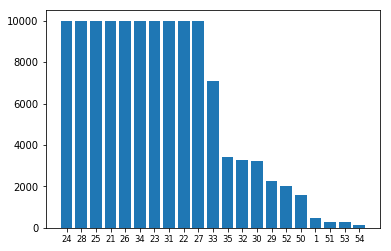

In [0]:
print("\nПример текста заявок =")
print(texts['Text'].tail(20))

print("\nКоличество классов =")
# print(texts['Code'].value_counts())

df = pd.Series(texts['Code'].value_counts())
pyplot.bar(range(len(df)), df.values, align='center')
pyplot.xticks(range(len(df)), df.index.values, size='small')
pyplot.show()

Видно, что текст заявок содержит массу лишней информации, типа знаков препинаний, спецсимволов и регистра символов. Также текст содержит слова в различных его формах (склонение, лицо, множественное число). Текст необходимо дополнительно обработать перед обучением нейронной сети.

Коды заявок в данных распределены неравномерно, записей с кодом 24, 28, 25, 21, 26, 34, 23, 31, 22, 27 по 10 000 штук, остальных меньше, половина классов представлена в маленьком количестве.

## 3. Предварительная обработка данных

Обработаем текст заявок так, чтобы его можно было использовать для обучения модели.


1.   Уберём все лишние спецсимволы
2.   Преобразуем все слова в их основыне формы - леммы.



### Очистка текста от спецсимволов

Для очистки символов используем библиотеку для работы с регулярными выражениями **re**.

In [0]:
line = "Разболтан электромеханический замок двери между пом.: Э-102/2 (секции: 11БН, 15БНН...) и Э004/2. Отв.: ЭЦ, СБ.".lower()
line = re.sub("[1234567890]", ' ', line)
line = re.sub("[\n\t_']", ' ', line)  # \n\t_'
line = re.sub('[!?@$%^&*+.,(){}#№;:~`<>|]', ' ', line)  # !?@$%^&*+.,(){}#№;:~`<>|
line = re.sub('[-+"«»±]', ' ', line)  # -+"
line = re.sub('[/\\\]', ' ', line)  # /\
line = re.sub('[/[/]]', ' ', line)    # []
print(line)

разболтан электромеханический замок двери между пом   э 102 2  секции  11бн  15бнн     и э004 2  отв   эц  сб 


### Преобразование слов в леммы

Для преобразования русского слов в их основную форму используем библиотеку **pymystem3**, обёртку для Python 3 программы Mystem, выполняющей морфологический анализ слов русского языка. [Программа Mystem](https://yandex.ru/dev/mystem/) была разработана в Яндексе тем самым Ильёй Сегаловичем.

*Нижеприведённый код почему-то не работает в Google Colab. Запустите его в обычном IDE.*

In [0]:
# https://github.com/nlpub/pymystem3
#!pip install pymystem3
from pymystem3 import Mystem

m = Mystem()
lemmas = m.lemmatize("Розетки, к которым подключена досмотровая установка, не отмаркированы")
print(lemmas)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


KeyboardInterrupt: ignored

Чтобы не делать преобразование слов в леммы каждый раз, обработаем сразу весь массив данных и результат сохраним. Перед этим не забудем убрать из записей все ненужные нам символы.

In [0]:
def get_lemma(original_text):
    m = Mystem()
    line = original_text.lower()
    # уберём все плохие символы
    line = re.sub("[1234567890]", ' ', line)
    line = re.sub("[\n\t_']", ' ', line)  # \n\t_'
    line = re.sub('[!?@$%^&*+.,(){}#№;:~`<>|]', ' ', line)  # !?@$%^&*+.,(){}#№;:~`<>|
    line = re.sub('[-+"«»±]', ' ', line)  # -+"
    line = re.sub('[/\\\]', ' ', line)  # /\
    line = re.sub('[/[/]]', ' ', line)    # []

    # получим леммы
    lemmas = m.lemmatize(line)
    lemmas = [a.strip() for a in lemmas]
    lemmas = list(filter(lambda a: a != "", lemmas))    # удалим все пробелы
    result = " ".join(lemmas)
    return result


# преобразование данных, замена текста списком лемм
def data_word_to_lemma():
    d = pd.read_csv("journals.txt", sep = "\t")
    # d = d[:100] # для скорости используем только часть строк
    d.dropna()
    print("размер массива данных = ", d.shape)
    col = list(d)
    if col[0] != "Text":
        print("У данных должно быть два столбцы, разделённых табулятором с заголовками Text и Code")

    # заменим оригинальный тест на перечень лемм слов текста
    for i in range(d.shape[0]):
        print(">%d/%d" % (i + 1, d.shape[0]))

        caption = d[col[0]][i]
        # print(caption)
        caption = get_lemma(caption)
        # print(caption)
        d[col[0]][i] = caption

    d.to_csv("journals-lemma.txt", sep = "\t", index = False, header = col)
    return d, col


data_word_to_lemma()

Таким образом у нас получился файл *journals-lemma.txt*, с которым мы и будем в дальнейшем работать.

In [0]:
data = pd.read_csv("journals-lemma.txt", sep = "\t")
data.dropna()
print("Размер массива данных = ", data.shape)

print("\nПример данных =")
print(data.head(10))

Размер массива данных =  (123966, 2)

Пример данных =
                                                Text  Code
0  от переходный галерея диагностический центр к ...     1
1                     нет допуск згиэ в здание дгсаэ     1
2             подклинивать наружный дверь шлюз бщу 4     1
3  розетка к который подключать досмотровый устан...     1
4  выполнять обход по маршрут 4 7 ответный планка...     1
5     слетать крышка с несколько короб на ограждение     1
6  выполнять обход по маршрут 5 обход бнс 2 не пр...     1
7  выполнять обход по маршрут 15 на бщу 1 на пуль...     1
8  алк кпп рентгенустановка разбираться с пилот е...     1
9  выполнять обход по маршрут 5 на бнс 2 обход не...     1


Видно, что текст записей изменился

In [0]:
print("\nПример текста заявок =")
print(data['Text'].tail(20))


Пример текста заявок =
123946    для цтаи бщу 1 сврк периодически отбраковывать...
123947    выполнять обход по маршрут 35 44 замечание пом...
123948    выполнять обход по маршрут 35 41 записывать за...
123949    второй абзац п 4 3 1 производственный инструкц...
123950    выполнять обход по маршрут 35 40 замечание не ...
123951    на постамент реактор блок 2 не работать телефо...
123952    выполнять обход по маршрут 35 42 записоно заме...
123953    выполнять обход по маршрут 35 39 замечание пом...
123954    для оикт не работоспособный прямой громкий свя...
123955    для ццрвыполнять обход по маршрут 35 41 замеча...
123956    выполнять обход по маршрут 35 47 записывать за...
123957    выполнять обход по маршрут 35 43 записывать за...
123958    выполнять обход по маршрут 35 40 записывать за...
123959    для орб записывать замечание орб 2019 00358 в ...
123960    в инструментальный ящик gedore лабораторный ко...
123961    в технологический регламент эксплуатация бл 3 ...
123962    выполн

## 4. Подготовка данных для обучения сети

Для того, чтобы обучить сеть, нужно подготовить пару массивов - массив входных данных **X** и массив выходных данных **y**. Чем качественней вы приготовите данные для обучения, тем качественней вы получите модель.

### Кодирование текста (подготовка массива X)

Чтобы обучить нейронную сеть, ей нужно передать данные в том виде, который ей понятен, на основе которой она сможет подобрать хорошие весовые коэффициенты и потом сделать эффективные прогнозы.

Такой понятной формой для сети является числовая матрица. Преобразуем слова из предложений в последовательность чисел.

Для этого используем модуль Tokenizer из библиотеки Keras. Tokenizer позволяет преобразовать слова в индексы этих слов из словаря всех слов, которые используются в конкретной обработке.

In [0]:
tokenizer = Tokenizer()
# готовим словарь всех используемых слов
tokenizer.fit_on_texts(["мамы разные нужны мамы разные важны дело было вечером делать было нечего"]) 
# преобразуем текст в последовательность
text = ["мамы разные нужны мамы разные важны"]
sequences = tokenizer.texts_to_sequences(text)

print("Весь словарь = ")
print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index)
print('Словарь состоит из %d слов' % vocab_size)
print("Оригинальное предложение - ", text)
print("Преобразованное предложение - ", sequences)

Весь словарь = 
{'мамы': 1, 'разные': 2, 'было': 3, 'нужны': 4, 'важны': 5, 'дело': 6, 'вечером': 7, 'делать': 8, 'нечего': 9}
Словарь состоит из 9 слов
Оригинальное предложение -  ['мамы разные нужны мамы разные важны']
Преобразованное предложение -  [[1, 2, 4, 1, 2, 5]]


Но в массиве заявок все заявки имеют разную длину в словах, а наша будущая модель может принимать массивы только одинаковой длины.

Воспользуемся функцией from **pad_sequences**, которая может обрезать или дополнять последовательность, чтобы она была заданной длины. В нашем случае, мы заранее найдём максимальную длину в словах текста заявки и дополним все преобразованные в последовательности заявки до этой максимальной длины.

Это работает так - 

In [0]:
max_len = 10
X = pad_sequences(sequences, maxlen=max_len)
print (X)

[[0 0 0 0 1 2 4 1 2 5]]


Как мы подготовим массив входных данных X понятно, теперь разберёмся, как мы подготовим массив выходных данных y, на котором мы будем обучать нашу нейронную сеть.

### Кодирование меток (подготовка массива y)

Как вы помните, у нас каждому тексту заявки поставлен в соответствие класс этой заявки. В основном, это следующие классы:


```
ID	NAME
1	 Режим и физическая защита
21	Маркировка
22	Эксплуатационный порядок
23	Документация
24	Состояние электротехнического оборудования
25	Состояние тепломеханического оборудования
26	Состояние помещений, зданий и сооружений
27	Состояние КИПиА
28	Охрана труда
29	Оперативные переговоры
30	Оперативные переключения
31	Вскрытое оборудование
32	Программное обеспечение АСУП
33	Ремонтная площадка
34	Пожарная безопасность
35	Состояние территории
50	Система 5С на рабочем месте
51	Обращение с химической продукцией
52	Персонал
53	Предложения по улучшению эксплуатации
54	Ядерная безопасность
```



Номера классов идут не попорядку, значит в соответсвии с принципами нормализации, нам нужно эти коды классов изменить на нормализованные. В нашем случае, изменим их на идущие по порядку целые числа.

Но нейронная сеть при обучении будет искать в этих идущих по порядку целых числах какую-то связь, какой-то порядок. Поэтому, следует дополнительно номера этих классов подвергнуть унитарному кодированию.

Унитарное кодирование - это преобразование целочисленных меток в их бинарные аналоги (на самом деле, не совсем). А точнее, в случае кодирования целых чисел от 1 до 4, мы получим четыре бинарные метки каждая из четырёх бит, в котором все биты будут нулями, кроме одного, который стоит в позиции, соответствующей этому коду класса. То есть - 


```
Метка   Код
1       1000
2       0100
3       0010
4       0001
```




Унитарное кодирование можно выполнить с помощью функции **OneHotEncoder**.  Например, так

In [0]:
codes = np.array([2, 1, 4, 3])
oh_coder = OneHotEncoder(categories='auto', sparse = False)
codes = codes.reshape(len(codes), 1)
print("Категории - \n", codes)
y = oh_coder.fit_transform(codes)
print("Кодированные категории - \n", y)

Категории - 
 [[2]
 [1]
 [4]
 [3]]
Кодированные категории - 
 [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


### Функция подготовки данных

Теперь соберём вышеприведнный код в функцию, которая будет готовить нашей модели массивы входных и выходных данных X и y. 

Функция получает перечень классов, которые нужно включить в обучающую выборку (вы же помните, что некоторые классы у нас хорошо представлены, по 10 тысяч строк на класс, а некоторые - очень слабо).

Обратно функция возвращает массив X, состоящий из одинаковых по размеру последовательностей индексов слов из каждого описания заявки, и массив y, состоящий из соответствующего этой заявке классу, закодированному в бинарную последовательность.

In [0]:
def get_X_y(classes_array, num_rec_for_class=100000):
    # загрузим весь массив
    data = pd.read_csv('journals-lemma.txt', sep = "\t")
    data = data.dropna()
    # классы
    #print("Класс Кол-во записей")
    #print(data['Code'].value_counts())
    
    # количество классов в конечной выборке
    num_classes = len(classes_array)
    # возьмём из массива только нужные нам классы
    shuffled = data.reindex(np.random.permutation(data.index))
    concated = data.head(0)
    
    i = 0
    labels = []
    for good_class in classes_array:
        labels.append(good_class)
        a = shuffled[shuffled['Code'] == good_class][:num_rec_for_class]
        a['Code'] = i
        concated = pd.concat([concated, a], ignore_index = True)
        i += 1

    # массив только с нужными классами
    data = concated.reindex(np.random.permutation(concated.index))
    # print("Кол-во записей по классам:")
    # print(data['Code'].value_counts())
    
    # длина максимального текста в словах
    max_len = 0
    words_count = []
    for i in range(data.shape[0]):
        text = data['Text'][i]
        l = len(text.split())
        words_count.append(l)         
        if max_len < l: max_len = l

    print('Самое длинное предложение - из %d слов' % max_len)
    l = round(np.mean(words_count) + (np.max(words_count) - np.mean(words_count))/4)
    max_len = int(l)
    print('Сократим до разумной длины в %d слов' % max_len)
            
    # унитарное кодирование
    oh_coder = OneHotEncoder(categories='auto', sparse = False)
    yy = data['Code'].values
    yy = yy.reshape(len(yy), 1)
    yy = oh_coder.fit_transform(yy)
    
    # последовательности индексов слов
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['Text'].values)
    vocab_size = len(tokenizer.word_index)
    print('Словарь состоит из %d слов' % vocab_size)
    sequences = tokenizer.texts_to_sequences(data['Text'].values)
    XX = pad_sequences(sequences, maxlen=max_len, padding = "post")
    
    return XX, yy, max_len, vocab_size, num_classes, tokenizer, oh_coder, labels

Проверим работу функции, получив небольшую выборку (из 100 записей) для трёх случайных классов - 21, 28 и 31.

In [0]:
X, y, max_len, vocab_size, num_classes, tokenizer, oh_coder, labels = get_X_y([21, 28, 31], 100)
print("Размерность массива входных данных - ", X.shape)
print("Входные данные массива X (первые два) - \n", X[:2])
print("Размерность массива выходных данных - ", y.shape)
print("Выходные данные массива y (первые два) - \n",y[:2])
print("Метки классов записей - ", labels)

Самое длинное предложение - из 189 слов
Сократим до разумной длины в 64 слов
Словарь состоит из 1753 слов
Размерность массива входных данных -  (300, 64)
Входные данные X (первые два) - 
 [[  5   3   1   6   7  10  22 160 422   4 423  11 424 679 199 161   4 680
  681  71 682 683  45  76   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  5   3   1   6  52   9  12   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
Размерность массива выходных данных -  (300, 3)
Выходные данные y (первые два) - 
 [[0. 1. 0.]
 [0. 0. 1.]]
Метки классов записей -  [21, 28, 31]


Полученный массив для обучения этим трём классам имеет 629 строк с максимальной длинной текста в 282 слова. Так как мы взяли только три класса, массив меток имеет размерность 3.

Данные подготовлены, займёмся моделью сети.

## 5. Строим модель нейронной сети

Модель нейронной сети, которую мы будем строить, будет многослойной, её ядром будет слой LSTM (Long short-term memory, Долгая краткосрочная память) - вариант реккурентной нейронной сети (RNN), которая показывает хорошие результаты на подобных задачах.

Кроме LSTM наша модель будет содержать и другие слои.

Рассмотрим чуть подробнее, что это за слои.

*   **Embedding** - специальный слой, предназначенный для обработки естественного языка, выполняет предварительную подготовку данных для слоя LSTM. Имеет следующие входные параметры: *input_dim* - размерность входного массива, это размер нашего словаря. *output_dim* - размерность выходного массива, который будет передан на следующий слой. *input_length* - длина наших входных последовательностей, т.е. максимальная длина наших заявок в словах;
*  **SpatialDropout1D** - это усовершенствованный слой Dropout, предназначенный для борьбы с переобучением сети. Но если слой Dropout случайным образом исключает один нейрон из сети, то в слое SpatialDropout1D происходит исключение группы нейронов. Параметры: *rate* - вероятность исключения группы нейронов из сети;
*  **LSTM** - ядро нашей модели, слой, который сделает основную работу. Параметры: *units* - количество ячеек памяти модели LTSM, это же число задаёт размерность данных на выходе из слоя;
* **Dense** - полносвязный слой, просто объединяющий все данные из предыдущего слоя. Параметры: *units* - размерность выходных данных, *activation* - способ объединения данных с предыдущего слоя, а так как у нас задача на многоклассовую классификацию, то для таки задачь необходимо использовать активацию типа softmax;

Запустим код, компилирующий модель.


In [0]:
mem_cells = 150
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=mem_cells, input_length=max_len))
# model.add(SpatialDropout1D(rate=0.2))
model.add(LSTM(units=mem_cells, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(LSTM(units=mem_cells, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

W0723 06:36:29.151169 140709683365760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 06:36:29.200317 140709683365760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 06:36:29.207787 140709683365760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 06:36:29.393424 140709683365760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 06:36:29.406786 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 150)           263100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 150)           180600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 453       
Total params: 624,753
Trainable params: 624,753
Non-trainable params: 0
_________________________________________________________________
None


При компиляции функцией **compile()** дополнительно указываются следующие параметры -


*   optimizer - это оптимизационный алгоритм, который использует сеть при подборе весов сети, мы использовали популярный алгоритм *adam*;
*   loss - функция подсчёта потерь, используемый сетью для оптимизации весов, так как у нас задача многоклассововй классификации, то нужно использовать функцию* categorical crossentropy*;
*   metrics - тут можно указать метрики, значения которых сохраняются по мере обучения сети, чтобы потом можно было проанализировать их изменение, мы хотим смотреть на изменение точности сети (метрика *acc* - accuracy);

Модель успешно скомпилирована, можно посмотреть список содержащихся в ней слоёв, размерность данных в этих слоях и итоговое количество параметров, подлежащих обучению.

## 6. Обучение сети

Обучение сети проводиться на наборах входных и выходных данных (X и y), которые мы предварительно подготовили. 

Для обучения принято использовать только часть данных, а часть - спрятать и не показывать пока сети, чтобы потом на этих спрятанных данных проверить качество обученной сети.

Для этого нужно наши данные разбить на два набора - обучающие данные и тестовые данные. Оба эти набора будут содержать пару X и y. 

Разобъём данные с помощью функции **train_test_split()**. В параметрах функции указываем наборы данных для разбиения, относительный размер проверочного набора и следует ли перемешать разбиваемый набор данных перед разделением.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(270, 64) (270, 3)
(30, 64) (30, 3)


Обучение нейронной сети проходит в несколько заходов, они называются эпохи. Одна эпоха - это один проход по всем обучающим данным. Количество эпох (*epochs*), используемые при обучении - это один из параметров обучения. 

Так как данных много и их все сразу не прогнать через сеть, сеть обучается только на части данных, так называемом пакете данных. Размер этого пакета (*batch_size*) - один из параметров, указываемый при обучении.

In [0]:
# n_cells=32, n_epochs=5, batch_size=10
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
270/270 [==============================] - 4s 16ms/step - loss: 0.6457 - acc: 0.6185
Epoch 2/20
270/270 [==============================] - 4s 15ms/step - loss: 0.7562 - acc: 0.6296
Epoch 3/20
270/270 [==============================] - 4s 15ms/step - loss: 0.6768 - acc: 0.6370
Epoch 4/20
270/270 [==============================] - 4s 15ms/step - loss: 0.6776 - acc: 0.6111
Epoch 5/20
270/270 [==============================] - 4s 15ms/step - loss: 0.6505 - acc: 0.6815
Epoch 6/20
270/270 [==============================] - 4s 16ms/step - loss: 0.6408 - acc: 0.6889
Epoch 7/20
270/270 [==============================] - 4s 16ms/step - loss: 0.6592 - acc: 0.6778
Epoch 8/20
270/270 [==============================] - 4s 16ms/step - loss: 0.7121 - acc: 0.6741
Epoch 9/20
270/270 [==============================] - 4s 16ms/step - loss: 0.7206 - acc: 0.6481
Epoch 10/20
270/270 [==============================] - 4s 16ms/step - loss: 0.7126 - acc: 0.6741
Epoch 11/20
270/270 [==================

После обучения на очередной эпохе, показатель функции потерь (loss) должен падать, в идеале до 0, а показатель точности сети (acc, accuracy) должен расти, в идеале до 1.

## 7. Прогноз на основе обученной сети

Чтобы сделать прогноз на обученной сети, нужно вызвать функцию **predict()**. Функция в качестве входных параметров принимает массив X.

Попробуем сделать прогноз для одной из заявок, которая оказалась у нас в тестовом наборе и наша сеть её ещё не видела.

In [0]:
print("Закодированный текст заявки -\n", X_test[0])
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# print(reverse_word_map)
original_text = [reverse_word_map.get(letter) for letter in X_test[0]]
print("Оригинальный текст заявки -\n", original_text)

# получим прогноз для всех тестовых данных
y_pred = model.predict(X_test, batch_size=32)

print("Прогнозные вероятности принадлежности к классам заявки -", y_pred[0])
print("Классы заявок в массиве данных - ", labels)
c_pred = oh_coder.inverse_transform([y_pred[0]])[0][0]
print("Прогноз класса для этой заявки - ", labels[c_pred])
c_test = oh_coder.inverse_transform([y_test[0]])[0][0]
print("Реальный класс этой заявки - ", labels[c_test])

Закодированный текст заявки -
 [   5    3    1    6    7   10  261  456   81 1351 1352  638  108   20
   20   32   14   27   10   22  142  639    4   62    2 1353 1354   97
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Оригинальный текст заявки -
 ['выполнять', 'обход', 'по', 'маршрут', '1', '2', 'территория', 'каэс', 'здание', 'станция', 'зарядка', 'огнетушитель', 'отметка', '0', '0', 'ряд', 'а', 'ось', '2', 'отсутствовать', 'маркировочный', 'таблица', 'на', 'дверь', 'в', 'тамбур', 'сзо', '11', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Прогнозные вероятности принадлежности к классам заявки - [0.3320846  0.08089004 0.5870254 ]
Классы заявок в массиве данных -  [21, 28, 31]
Прогно

В результате прогноза мы получим массив вероятностей того, что переданный нейронной сети текст принадлежит к определённым классам.

С помощью функции **inverse_transform** нашего унитарного кодировщика мы получим номер класса, спрогнозированного сетью.

## 8. Оценка сети

После обучения нужно убедиться в качестве обученной сети. Это можно сделать несколькими способами. Простой способ получить значение точности сети - сделать прогноз и сравнить его с реальными данными.

In [0]:
y_pred = model.predict(X_test, batch_size=32)
wrong = 0
for i in range(len(y_pred)):
    real_val = oh_coder.inverse_transform([y_test[i]])
    predict_val = oh_coder.inverse_transform([y_pred[i]])
    print("%d/%d ждали - %d, получили - %d. Это правильно - %s" % (i, len(y_pred), real_val, predict_val, (real_val == predict_val)[0][0]))
    if real_val != predict_val:
        wrong = wrong + 1
        
accr = (len(y_pred) - wrong) / len(y_pred)
print('Точность: {:0.1f}%'.format(accr*100))

0/30 ждали - 0, получили - 2. Это правильно - False
1/30 ждали - 2, получили - 2. Это правильно - True
2/30 ждали - 2, получили - 2. Это правильно - True
3/30 ждали - 2, получили - 2. Это правильно - True
4/30 ждали - 1, получили - 2. Это правильно - False
5/30 ждали - 0, получили - 2. Это правильно - False
6/30 ждали - 0, получили - 0. Это правильно - True
7/30 ждали - 2, получили - 2. Это правильно - True
8/30 ждали - 0, получили - 1. Это правильно - False
9/30 ждали - 0, получили - 1. Это правильно - False
10/30 ждали - 2, получили - 2. Это правильно - True
11/30 ждали - 0, получили - 2. Это правильно - False
12/30 ждали - 1, получили - 1. Это правильно - True
13/30 ждали - 0, получили - 2. Это правильно - False
14/30 ждали - 1, получили - 1. Это правильно - True
15/30 ждали - 2, получили - 2. Это правильно - True
16/30 ждали - 0, получили - 1. Это правильно - False
17/30 ждали - 1, получили - 1. Это правильно - True
18/30 ждали - 2, получили - 2. Это правильно - True
19/30 ждали - 

Также узнать качество обученной сети можно с помощью специальной функции **evaluate()**. 

Функции нужно передать тестовый набор входных и выходных данных. Сеть по входным данным сделает прогноз, сравнит его с тестовыми выходными данными и выдаст оценку качества обученной сети.

In [0]:
accr = model.evaluate(X_test,y_test)
print('Оценка по тестовому набору данных\n  Потери: {:0.2f}\n  Точность: {:0.1f}%'.format(accr[0],accr[1]*100))

30/30 [==============================] - 1s 17ms/step
Оценка по тестовому набору данных
  Потери: 0.81
  Точность: 63.3%


## 9. Настройка сети

Не очень хорошие показатели качества обученной сети можно улучшить двумя способами -


1.   Бо́льшим количеством качественных данных;
2.   Тонкой настройкой гиперпараметров сети;



### Увеличение количества данных

Ранее мы учились прогнозировать три класса заявок на выборке по 100 записей на каждый класс.

В этот раз обучим сеть узнавать эти же классы, но на выборке из 10 000 записей на каждый класс.

In [0]:
# получим данные
X, y, max_len, vocab_size, num_classes, tokenizer, oh_coder, labels = get_X_y([21, 28, 31], 10000)
print("Размерность массива входных данных - ", X.shape)
print("Входные данные массива X (первые два) - \n", X[:2])
print("Размерность массива выходных данных - ", y.shape)
print("Выходные данные массива y (первые два) - \n",y[:2])
print("Метки классов записей - ", labels)

Самое длинное предложение - из 304 слов
Сократим до разумной длины в 92 слов
Словарь состоит из 26332 слов
Размерность массива входных данных -  (30000, 92)
Входные данные массива X (первые два) - 
 [[ 255   19 7223 5326    8    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   5    4    1    6   70   24   16   12    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  

В этот раз массив для обучения имеет 30 тысяч строк с максимальной длинной текста в 92 слова и словарём из 26 тысяч слов.

Обучим и оценим сеть на новых данных, но с теми же самыми параметрами, которые мы использовали ранее.

In [0]:
# разбивка данных на обучающий и проверочный набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# строим модель
mem_cells = 150
n_epochs = 20
b_size = 32
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=mem_cells, input_length=max_len))
# model.add(SpatialDropout1D(rate=0.2))
model.add(LSTM(units=mem_cells, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(LSTM(units=mem_cells, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
# обучение модели
model.fit(X_train, y_train, epochs=n_epochs, batch_size=b_size)
# оценка модели
accr = model.evaluate(X_test,y_test)
print('Оценка по проверочному набору данных\n  Потери: {:0.2f}\n  Точность: {:0.1f}%'.format(accr[0],accr[1]*100))

(27000, 92) (27000, 3)
(3000, 92) (3000, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 92, 150)           3950100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 92, 150)           180600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 453       
Total params: 4,311,753
Trainable params: 4,311,753
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
27000/27000 [==============================] - 611s 23ms/step - loss: 1.0992 - acc: 0.3326
Epoch 2/20
27000/27000 [==============================] - 626s 23ms/step - loss: 1.0857 - acc: 0.3595
Epoch 3/20


Сравним полученные результаты с тем, что было на выборке из 100 записей на один класс.

```
Кол-во записей: 100 шт   10 000 шт
Потери:         0.81     0.61
Точность:       63.3%    86.8%
```

Качество сети уже достаточно выросло, попробуем повысить его дополнительно, проведя тонкую настройку гиперпараметров сети.

### Подбор гиперпараметров сети

Подготовим несколько функций, с помощью которых можно настроить гиперпараметры сети.

In [0]:
# определение и компиляция модели
def get_model(n_cells, summary=True):
    m = Sequential()
    m.add(Embedding(input_dim=vocab_size+1, output_dim=n_cells, input_length=max_len))
#     m.add(SpatialDropout1D(rate=0.2))
#     m.add(LSTM(units=n_cells, dropout=0.2, recurrent_dropout=0.2))
    m.add(LSTM(units=n_cells, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
    m.add(LSTM(units=n_cells, dropout=0.1, recurrent_dropout=0.1))
    m.add(Dense(units=num_classes, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if summary: print(m.summary())
    return m

# настройка количества эпох
def tune_epochs_num(n_cells, n_epochs, batch_size):
    m = get_model(n_cells)
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001)
    history = m.fit(X, y, epochs=n_epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)
    
    # график потерь на обучающих и проверочных данных
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('потери сети на обучающих и на проверочных данных')
    pyplot.ylabel('потери')
    pyplot.xlabel('эпохи')
    pyplot.legend(['обучающие данные', 'проверочные данные'], loc = 'upper right')
    pyplot.show()
    
    # график точности
    acc = history.history['acc']
    acc = [x * 100. for x in acc]
    val_acc = history.history['val_acc']
    val_acc = [x * 100. for x in val_acc]
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.title('точность сети на обучающих и на проверочных данных')
    pyplot.ylabel('точность')
#     pyplot.xlabel('эпохи')
    pyplot.legend(['обучающие данные', 'проверочные данные'], loc = 'best')
    pyplot.show()
    
# оценка модели и получение размера потерь
def get_loss_acc(n_cells, n_epochs, batch_size, summary=False, early_stop=False):
    m = get_model(n_cells, summary)
    es = EarlyStopping(monitor='val_loss', min_delta=0.0001)
    if early_stop:
        history = m.fit(X, y, epochs=n_epochs, batch_size=batch_size, validation_split=0.1, shuffle=True, callbacks=[es])
    else:
        history = m.fit(X, y, epochs=n_epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)

    loss = history.history['val_loss'][len(history.history['val_loss'])-1]
    acc =  history.history['val_acc'][len(history.history['val_acc'])-1]
    return loss, acc

# настройка количества ячеек памяти    
def tune_memory_cells(mem_cells, n_epochs, batch_size):
    n_repeats = 3
    # массив для результатов подбора
    scores_loss = pd.DataFrame()
    scores_acc = pd.DataFrame()

    iteratio = 0
    for value in mem_cells:
        # повторяем каждый эксперимент несколько раз
        loss_values = list()
        acc_values = list()
        for i in range(n_repeats):
            print(">%d/%d (%d ячеек), проход %d из %d, тестируем...." % 
                  (iteratio*n_repeats + i + 1, len(mem_cells)*n_repeats, value, i + 1, n_repeats))
            loss, acc = get_loss_acc(n_cells=value, n_epochs=n_epochs, batch_size=batch_size)
            acc = acc * 100.
            loss_values.append(loss)
            acc_values.append(acc)
            print('>>%d/%d (%d ячеек), проход %d из %d, потери = %f, точность = %f' %
                  (iteratio*n_repeats + i + 1, len(mem_cells)*n_repeats, value, i + 1, n_repeats, loss, acc))

        # сохраним результаты для этого кол-ва ячеек
        scores_loss[str(value)] = loss_values
        scores_acc[str(value)] = acc_values
        iteratio += 1

    # итоговая статистика
    print("\nПОТЕРИ:\n", scores_loss.describe())
    print("\nТОЧНОСТЬ:\n", scores_acc.describe())

    # строим диаграмму размаха
    scores_loss.boxplot()
    pyplot.title('потери сети при подборе кол-ва яееек памяти')
    pyplot.ylabel('потери')
    pyplot.xlabel('кол-во ячеек')
    pyplot.show()
    
    scores_acc.boxplot()
    pyplot.title('качество модели при подборе кол-ва яееек памяти')
    pyplot.ylabel('точность')
    pyplot.xlabel('кол-во ячеек')
    pyplot.show()

# настройка размера пакета
def tune_batch_size(sizes, n_cells, n_epochs):
    n_repeats = 3
    # массив для результатов подбора
    scores_loss = pd.DataFrame()
    scores_acc = pd.DataFrame()

    iteratio = 0
    for value in sizes:
        # повторяем каждый эксперимент несколько раз
        loss_values = list()
        acc_values = list()
        for i in range(n_repeats):
            print(">%d/%d (размер пакета %d), проход %d из %d, тестируем...." % 
                  (iteratio*n_repeats+i+1, len(sizes)*n_repeats, value, i + 1, n_repeats))
            loss, acc = get_loss_acc(n_cells=n_cells, n_epochs=n_epochs, batch_size=value)
            acc = acc * 100.
            loss_values.append(loss)
            acc_values.append(acc)
            print('>>%d/%d (размер пакета %d), проход %d из %d, потери = %f, точность = %f' %
                  (iteratio*n_repeats+i+1, len(sizes)*n_repeats, value, i + 1, n_repeats, loss, acc))

        # сохраним результаты для этого кол-ва ячеек
        scores_loss[str(value)] = loss_values
        scores_acc[str(value)] = acc_values
        iteratio += 1

    # итоговая статистика
    print("\nПОТЕРИ:\n", scores_loss.describe())
    print("\nТОЧНОСТЬ:\n", scores_acc.describe())

    # строим диаграмму размаха
    scores_loss.boxplot()
    pyplot.title('потери сети при подборе размера пакета')
    pyplot.ylabel('потери')
    pyplot.xlabel('размер пакета')
    pyplot.show()
    
    scores_acc.boxplot()
    pyplot.title('качество модели при подборе размера пакета')
    pyplot.ylabel('точность')
#     pyplot.xlabel('размер пакета')
    pyplot.show()

Теперь займёмся тонким подбором гиперпараметров. В нашей модели нейронной сети таких три:


1.   Количество обучающих эпох
2.   Количество ячеек памяти в слое LTSM
3.   Размер пакета данных в эпохе


### Подбор количества эпох

Сначала определим достаточное для обучения количество эпох. Используем для начала какое-то большое количество эпох и посмотрим, как ведёт себя функция потерь во время обучения на этих эпохах.

В результате выполнения функции мы получим график изменения потерь с соответствием с количеством эпох.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 92, 150)           3950100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 92, 150)           180600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 453       
Total params: 4,311,753
Trainable params: 4,311,753
Non-trainable params: 0
_________________________________________________________________
None
Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 623s 23ms/step - loss: 1.0986 - acc: 0.3393 - val_loss: 1.0988 - val_acc: 0.3270
Epoch 2/20
27000/27000 [==============================] - 644s 24ms/ste

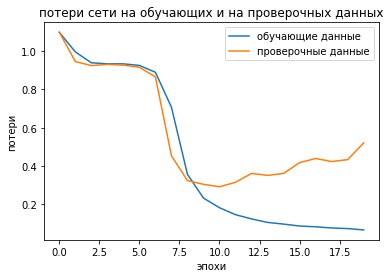

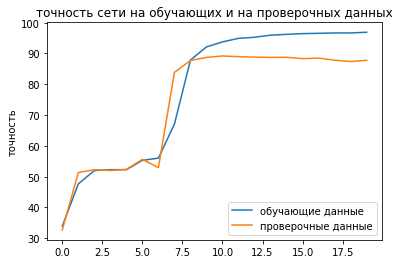

In [0]:
# n_epochs=11, n_cells=32, n_epochs=5
tune_epochs_num(n_epochs=20, n_cells=150, batch_size=32)

На графике видно, что на 9 эпохе размер потерь стабилизировался и перестал падать, точность перестала увеличиваться, значит, зафиксируем количество эпох на 9, как оптимальный размер обучающих эпох для данной сети.

### Подбор количества ячеек памяти

Подберём следующий параметр - количество ячеек памяти в слое LTSM. Функция подбора для разного значения количества ячеек памяти несколько раз выполняет обучение и оценку получившейся модели. Полученные значения усредняются и выводятся в виде диаграммы размаха, которая поможет выбрать лучшее значение.

W0725 18:08:37.275343 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 18:08:37.314610 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 18:08:37.322241 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 18:08:37.457630 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0725 18:08:37.468028 

>1/6 (100 ячеек), проход 1 из 2, тестируем....


W0725 18:08:38.326225 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 18:08:38.353738 140037041108864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 18:08:38.520735 140037041108864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27000 samples, validate on 3000 samples
Epoch 1/9
27000/27000 [==============================] - 359s 13ms/step - loss: 1.0991 - acc: 0.3391 - val_loss: 1.0985 - val_acc: 0.3390
Epoch 2/9
27000/27000 [==============================] - 355s 13ms/step - loss: 1.0187 - acc: 0.4382 - val_loss: 1.0893 - val_acc: 0.3430
Epoch 3/9
27000/27000 [==============================] - 353s 13ms/step - loss: 1.0844 - acc: 0.3497 - val_loss: 1.0903 - val_acc: 0.3310
Epoch 4/9
27000/27000 [==============================] - 354s 13ms/step - loss: 1.0187 - acc: 0.4570 - val_loss: 0.9709 - val_acc: 0.5033
Epoch 5/9
27000/27000 [==============================] - 354s 13ms/step - loss: 0.9633 - acc: 0.5007 - val_loss: 0.9712 - val_acc: 0.4640
Epoch 6/9
27000/27000 [==============================] - 352s 13ms/step - loss: 0.9553 - acc: 0.5045 - val_loss: 0.9702 - val_acc: 0.4720
Epoch 7/9
27000/27000 [==============================] - 351s 13ms/step - loss: 0.8536 - acc: 0.5489 - val_loss: 0.7329 - v

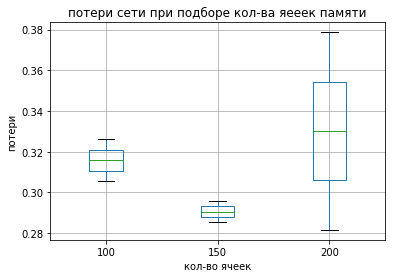

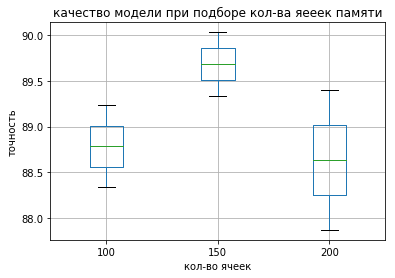

In [0]:
tune_memory_cells(mem_cells=[100, 150, 200], n_epochs=9, batch_size=32)

Видно, что потери минимальные и качество максимальное при количестве ячеек памяти равное 150.

### Подбор размера пакета

>1/8 (размер пакета 32), проход 1 из 2, тестируем....
Train on 27000 samples, validate on 3000 samples
Epoch 1/9
27000/27000 [==============================] - 369s 14ms/step - loss: 1.0992 - acc: 0.3314 - val_loss: 1.0988 - val_acc: 0.3210
Epoch 2/9
27000/27000 [==============================] - 363s 13ms/step - loss: 1.0990 - acc: 0.3490 - val_loss: 1.1041 - val_acc: 0.3213
Epoch 3/9
27000/27000 [==============================] - 363s 13ms/step - loss: 1.0996 - acc: 0.3294 - val_loss: 1.0984 - val_acc: 0.3517
Epoch 4/9
27000/27000 [==============================] - 363s 13ms/step - loss: 1.0989 - acc: 0.3370 - val_loss: 1.0979 - val_acc: 0.3283
Epoch 5/9
27000/27000 [==============================] - 369s 14ms/step - loss: 0.9486 - acc: 0.4988 - val_loss: 0.6335 - val_acc: 0.7517
Epoch 6/9
27000/27000 [==============================] - 371s 14ms/step - loss: 0.5777 - acc: 0.7780 - val_loss: 0.4457 - val_acc: 0.8413
Epoch 7/9
27000/27000 [==============================] - 374s 14ms/st

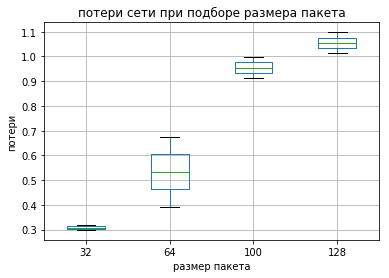

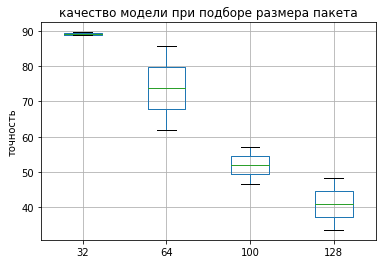

In [0]:
tune_batch_size(sizes=[32, 64, 100, 128], n_cells=150, n_epochs=9)

Видно, что при размере пакета в 32 выборки самые малые потери и самая большая точность сети.

Посмотрим, что получилось в результате подбора гиперпараметров.

In [0]:
loss, acc = get_loss_acc(n_cells=150, n_epochs=9, batch_size=32)
print('Оценка по тестовому набору данных\n  Потери: {:0.2f}\n  Точность: {:0.1f}%'.format(loss,acc*100.))

W0729 08:08:31.421320 140546966931328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27000 samples, validate on 3000 samples
Epoch 1/9
27000/27000 [==============================] - 370s 14ms/step - loss: 1.0990 - acc: 0.3434 - val_loss: 1.0985 - val_acc: 0.3350
Epoch 2/9
27000/27000 [==============================] - 364s 13ms/step - loss: 1.0680 - acc: 0.3879 - val_loss: 1.0989 - val_acc: 0.3297
Epoch 3/9
27000/27000 [==============================] - 363s 13ms/step - loss: 1.1006 - acc: 0.3389 - val_loss: 1.0974 - val_acc: 0.3437
Epoch 4/9
27000/27000 [==============================] - 366s 14ms/step - loss: 0.7765 - acc: 0.6146 - val_loss: 0.4522 - val_acc: 0.8350
Epoch 5/9
27000/27000 [==============================] - 369s 14ms/step - loss: 0.3470 - acc: 0.8781 - val_loss: 0.3453 - val_acc: 0.8667
Epoch 6/9
27000/27000 [==============================] - 369s 14ms/step - loss: 0.2472 - acc: 0.9122 - val_loss: 0.3377 - val_acc: 0.8643
Epoch 7/9
27000/27000 [==============================] - 368s 14ms/step - loss: 0.1988 - acc: 0.9276 - val_loss: 0.3229 - v

Сравним с предудущими значениями качества сети:


```
Кол-во записей: 100 шт   10 000 шт  Подбор
Потери:         0.81     0.61       0.35
Точность:       63.3%    86.8%      87.9%
```

Видно, что сильно упали потери и немного подросла точность сети.

## 10. Полная модель

Теперь, когда выбранная архитектура нейронной сети показала свою эффективность и мы отработали модель на части классов заявок, сделаем модель полноценной, работающей со всеми существующими классами заявок.

Параметры используемых данных -

```
Самое длинное предложение - из 429 слов
Сократим до разумной длины в 125 слов
Словарь состоит из 60882 слов
```



In [0]:
# получим данные
X, y, max_len, vocab_size, num_classes, tokenizer, oh_coder, labels = get_X_y(
    [24, 28, 25, 21, 26, 34, 23, 31, 22, 27, 33, 35, 32, 30, 29, 52, 50, 1, 51, 53, 54])
print("Размерность массива входных данных - ", X.shape)
print("Входные данные массива X (первые два) - \n", X[:2])
print("Размерность массива выходных данных - ", y.shape)
print("Выходные данные массива y (первые два) - \n",y[:2])
print("Метки классов записей - ", labels)

Самое длинное предложение - из 323 слов
Сократим до разумной длины в 96 слов
Словарь состоит из 31622 слов
Размерность массива входных данных -  (123964, 96)
Входные данные массива X (первые два) - 
 [[    5     3     1     6    36     8    44     2     1   504    30    95
     59   741  2886   197    49   581   833 10623    87 10623    50   741
   2886   197    49   581    65   131     1   581     8    12     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [   10    41    88    28   254    33  1079    38   632  6553  2110    43
   3512   345     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0    

Построим сеть, используя подобранные ранее параметры

In [0]:
loss, acc = get_loss_acc(n_cells=150, n_epochs=9, batch_size=32)
print('Оценка\n  Потери: {:0.2f}\n  Точность: {:0.1f}%'.format(loss,acc*100.))

Train on 111569 samples, validate on 12397 samples
Epoch 1/9
111569/111569 [==============================] - 2052s 18ms/step - loss: 2.7351 - acc: 0.0879 - val_loss: 2.7253 - val_acc: 0.0887
Epoch 2/9
111569/111569 [==============================] - 2060s 18ms/step - loss: 2.7341 - acc: 0.0858 - val_loss: 2.7397 - val_acc: 0.0778
Epoch 3/9
111569/111569 [==============================] - 2058s 18ms/step - loss: 2.7408 - acc: 0.0819 - val_loss: 2.7381 - val_acc: 0.0795
Epoch 4/9
111569/111569 [==============================] - 2072s 19ms/step - loss: 2.7413 - acc: 0.0798 - val_loss: 2.7425 - val_acc: 0.0795
Epoch 5/9
111569/111569 [==============================] - 2070s 19ms/step - loss: 2.7364 - acc: 0.0838 - val_loss: 2.7086 - val_acc: 0.1046
Epoch 6/9
111569/111569 [==============================] - 2065s 19ms/step - loss: 2.0575 - acc: 0.3496 - val_loss: 1.6033 - val_acc: 0.4998
Epoch 7/9
111569/111569 [==============================] - 2047s 18ms/step - loss: 1.4163 - acc: 0.5624

W0812 08:34:14.632028 139896238724992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 08:34:14.678043 139896238724992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 08:34:14.684692 139896238724992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 08:34:14.920049 139896238724992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0812 08:34:14.934517 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 96, 250)           7905750   
_________________________________________________________________
lstm_1 (LSTM)                (None, 96, 250)           501000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5271      
Total params: 8,913,021
Trainable params: 8,913,021
Non-trainable params: 0
_________________________________________________________________
None
Train on 111567 samples, validate on 12397 samples
Epoch 1/18
111567/111567 [==============================] - 203s 2ms/step - loss: 2.7344 - acc: 0.0868 - val_loss: 2.6669 - val_acc: 0.1224
Epoch 2/18
111567/111567 [==============================] - 197s 2ms

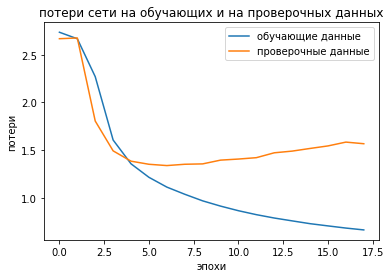

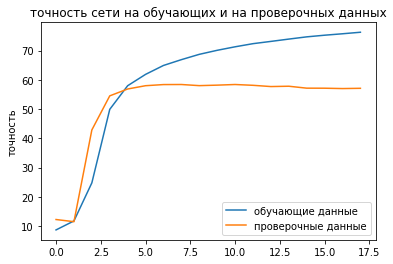

In [0]:
tune_epochs_num(n_epochs=18, n_cells=250, batch_size=320)

Видно, что после 3 обучающей эпохи график потерь на проверочных данных снова стал расти. Это говорит о переобученной модели. Устранить проблему переобученности можно только увеличив количество обучаемых данных. А их у нас больше нет.


W0809 11:48:01.612054 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 11:48:01.666249 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 11:48:01.675873 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



>1/9 (размер пакета 256), проход 1 из 3, тестируем....


W0809 11:48:01.929272 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0809 11:48:01.945590 140112931002240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0809 11:48:02.956106 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 11:48:02.989974 140112931002240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tenso

Train on 111567 samples, validate on 12397 samples
Epoch 1/12
111567/111567 [==============================] - 247s 2ms/step - loss: 2.6915 - acc: 0.1062 - val_loss: 2.7319 - val_acc: 0.0836
Epoch 2/12
111567/111567 [==============================] - 243s 2ms/step - loss: 2.6788 - acc: 0.1139 - val_loss: 2.5881 - val_acc: 0.1337
Epoch 3/12
111567/111567 [==============================] - 243s 2ms/step - loss: 2.5863 - acc: 0.1307 - val_loss: 2.5677 - val_acc: 0.1356
Epoch 4/12
111567/111567 [==============================] - 241s 2ms/step - loss: 2.5532 - acc: 0.1362 - val_loss: 2.4138 - val_acc: 0.2020
Epoch 5/12
111567/111567 [==============================] - 238s 2ms/step - loss: 2.1236 - acc: 0.2883 - val_loss: 1.8008 - val_acc: 0.4108
Epoch 6/12
111567/111567 [==============================] - 240s 2ms/step - loss: 1.5222 - acc: 0.5264 - val_loss: 1.4158 - val_acc: 0.5663
Epoch 7/12
111567/111567 [==============================] - 240s 2ms/step - loss: 1.2517 - acc: 0.6104 - val_

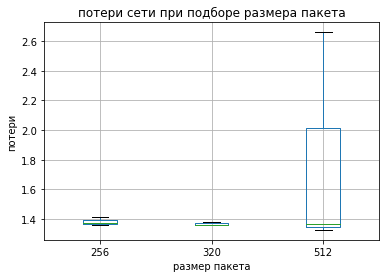

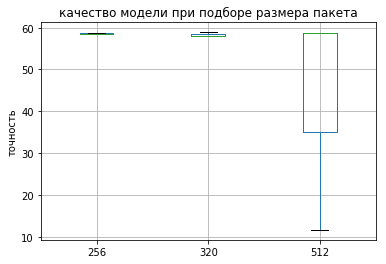

In [0]:
tune_batch_size(sizes=[256, 320, 512], n_cells=250, n_epochs=12)

In [0]:
tune_memory_cells(mem_cells=[128, 254, 320], n_epochs=3, batch_size=320)

>1/9 (128 ячеек), проход 1 из 3, тестируем....
Train on 111567 samples, validate on 12397 samples
Epoch 1/3
111567/111567 [==============================] - 173s 2ms/step - loss: 2.7122 - acc: 0.0933 - val_loss: 2.4893 - val_acc: 0.1837
Epoch 2/3
111567/111567 [==============================] - 166s 1ms/step - loss: 2.2185 - acc: 0.2590 - val_loss: 1.9558 - val_acc: 0.3812
Epoch 3/3
111567/111567 [==============================] - 167s 2ms/step - loss: 1.6992 - acc: 0.4695 - val_loss: 1.5610 - val_acc: 0.5213
>>1/9 (128 ячеек), проход 1 из 3, потери = 1.561040, точность = 52.133581
>2/9 (128 ячеек), проход 2 из 3, тестируем....
Train on 111567 samples, validate on 12397 samples
Epoch 1/3
111567/111567 [==============================] - 175s 2ms/step - loss: 2.7088 - acc: 0.0922 - val_loss: 2.6577 - val_acc: 0.1057
Epoch 2/3
111567/111567 [==============================] - 165s 1ms/step - loss: 2.6566 - acc: 0.1033 - val_loss: 2.6565 - val_acc: 0.1045
Epoch 3/3
111567/111567 [==========